In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
hbfd

NameError: name 'hbfd' is not defined

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import math
import torch.utils.checkpoint as cp

import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
from math import exp

import torchvision.transforms.functional as TF
from collections import OrderedDict


In [4]:
x_train_path = '../input/red-sample/train_blur/'
y_train_path = '../input/red-sample/train_sharp/'
x_test_path = '../input/red-sample/test_blur/'

In [5]:
train_x_img_paths = []
train_y_img_paths = []
test_img_paths = []

In [6]:
print(torch.__version__)

1.4.0


In [7]:
#12 16 24
block_config =(6, 10, 8)

In [8]:
for i in os.listdir(x_train_path):
    path = x_train_path+str(i)+"/"
    for j in os.listdir(path):
        train_x_img_paths.append(path+j)
for i in os.listdir(y_train_path):
    path = y_train_path+str(i)+"/"
    for j in os.listdir(path):
        train_y_img_paths.append(path+j)

## -----   test images
for i in os.listdir(x_test_path):
    path = x_test_path+str(i)
    test_img_paths.append(path)

In [9]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = len(train_x_img_paths)
        self.test_index = len(test_img_paths)
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return self.test_index
    def __getitem__(self, index):
        if self.is_train:
            img1 = (self.transform(mpimg.imread(train_x_img_paths[index])))
            img2 = (self.transform(mpimg.imread(train_y_img_paths[index])))
            img = img1.view(-1,img1.size(0),img1.size(1),img1.size(2))
            blur = F.upsample(img, size=(img.size(2)//2, img.size(3)//2), mode='bilinear').view(img1.size(0),img1.size(1)//2,img1.size(2)//2)
            img = img2.view(-1,img1.size(0),img1.size(1),img1.size(2))
            original = F.upsample(img, size=(img.size(2)//2, img.size(3)//2), mode='bilinear').view(img1.size(0),img1.size(1)//2,img1.size(2)//2)
            del img,img1,img2
#             original = (original-blur)
            return (blur,original)
        else:
            img1 = (self.transform(mpimg.imread(test_img_paths[index]))-0.5)/0.5
            img = img1.view(-1,img1.size(0),img1.size(1),img1.size(2))
            downsampled1 = F.upsample(img, size=(img.size(2)//2, img.size(3)//2), mode='bilinear').view(img1.size(0),img1.size(1)//2,img1.size(2)//2)
            return downsampled1

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
IMG_WIDTH = 1280//2
IMG_HEIGHT = 720//2
latent_size = 200

In [12]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super(DepthToSpace, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack,0).transpose(0,1).permute(0,2,1,3,4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super(SpaceToDepth, self).__init__()
        self.block_size = block_size
        self.block_size_sq = block_size*block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


In [13]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [14]:
scale_ratio = 2

In [15]:
def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate,
                        kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
            (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
        efficient (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
    """
    def __init__(self, growth_rate=2, block_config=(16, 16, 16), compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=0,
                 num_classes=10, small_inputs=True, efficient=True):

        super(DenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'

        # First convolution
        if small_inputs:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3*scale_ratio**2, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ]))
        else:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3*scale_ratio**2, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ]))
            self.features.add_module('norm0', nn.BatchNorm2d(num_init_features))
            self.features.add_module('relu0', nn.ReLU(inplace=True))
            self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
                                                           ceil_mode=False))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)

        # Final batch norm
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))

        # Linear layer
#         self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)
        
    def forward(self, x):
        features = self.features(x)
#         print(features.shape)
        out = F.relu(features, inplace=True)
#         print(out.shape)
        return features


In [16]:
class DeformConv2d(nn.Module):
    def __init__(self, inc, outc, kernel_size=3, padding=0, stride=1, bias=None, modulation=False):
        """
        Args:
            modulation (bool, optional): If True, Modulated Defomable Convolution (Deformable ConvNets v2).
        """
        super(DeformConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.zero_padding = nn.ZeroPad2d(padding)
        self.conv = nn.Conv2d(inc, outc, kernel_size=kernel_size, stride=kernel_size, bias=bias)

        self.p_conv = nn.Conv2d(inc, 2*kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
        nn.init.constant_(self.p_conv.weight, 0)
        self.p_conv.register_backward_hook(self._set_lr)

        self.modulation = modulation
        if modulation:
            self.m_conv = nn.Conv2d(inc, kernel_size*kernel_size, kernel_size=3, padding=1, stride=stride)
            nn.init.constant_(self.m_conv.weight, 0)
            self.m_conv.register_backward_hook(self._set_lr)

    @staticmethod
    def _set_lr(module, grad_input, grad_output):
        grad_input = (grad_input[i] * 0.1 for i in range(len(grad_input)))
        grad_output = (grad_output[i] * 0.1 for i in range(len(grad_output)))

    def forward(self, x):
        offset = self.p_conv(x)
        if self.modulation:
            m = torch.sigmoid(self.m_conv(x))

        dtype = offset.data.type()
        ks = self.kernel_size
        N = offset.size(1) // 2

        if self.padding:
            x = self.zero_padding(x)

        # (b, 2N, h, w)
        p = self._get_p(offset, dtype)

        # (b, h, w, 2N)
        p = p.contiguous().permute(0, 2, 3, 1)
        q_lt = p.detach().floor()
        q_rb = q_lt + 1

        q_lt = torch.cat([torch.clamp(q_lt[..., :N], 0, x.size(2)-1), torch.clamp(q_lt[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_rb = torch.cat([torch.clamp(q_rb[..., :N], 0, x.size(2)-1), torch.clamp(q_rb[..., N:], 0, x.size(3)-1)], dim=-1).long()
        q_lb = torch.cat([q_lt[..., :N], q_rb[..., N:]], dim=-1)
        q_rt = torch.cat([q_rb[..., :N], q_lt[..., N:]], dim=-1)

        # clip p
        p = torch.cat([torch.clamp(p[..., :N], 0, x.size(2)-1), torch.clamp(p[..., N:], 0, x.size(3)-1)], dim=-1)

        # bilinear kernel (b, h, w, N)
        g_lt = (1 + (q_lt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_lt[..., N:].type_as(p) - p[..., N:]))
        g_rb = (1 - (q_rb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_rb[..., N:].type_as(p) - p[..., N:]))
        g_lb = (1 + (q_lb[..., :N].type_as(p) - p[..., :N])) * (1 - (q_lb[..., N:].type_as(p) - p[..., N:]))
        g_rt = (1 - (q_rt[..., :N].type_as(p) - p[..., :N])) * (1 + (q_rt[..., N:].type_as(p) - p[..., N:]))

        # (b, c, h, w, N)
        x_q_lt = self._get_x_q(x, q_lt, N)
        x_q_rb = self._get_x_q(x, q_rb, N)
        x_q_lb = self._get_x_q(x, q_lb, N)
        x_q_rt = self._get_x_q(x, q_rt, N)

        # (b, c, h, w, N)
        x_offset = g_lt.unsqueeze(dim=1) * x_q_lt + \
                   g_rb.unsqueeze(dim=1) * x_q_rb + \
                   g_lb.unsqueeze(dim=1) * x_q_lb + \
                   g_rt.unsqueeze(dim=1) * x_q_rt

        # modulation
        if self.modulation:
            m = m.contiguous().permute(0, 2, 3, 1)
            m = m.unsqueeze(dim=1)
            m = torch.cat([m for _ in range(x_offset.size(1))], dim=1)
            x_offset *= m

        x_offset = self._reshape_x_offset(x_offset, ks)
        out = self.conv(x_offset)

        return out

    def _get_p_n(self, N, dtype):
        p_n_x, p_n_y = torch.meshgrid(
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1),
            torch.arange(-(self.kernel_size-1)//2, (self.kernel_size-1)//2+1))
        # (2N, 1)
        p_n = torch.cat([torch.flatten(p_n_x), torch.flatten(p_n_y)], 0)
        p_n = p_n.view(1, 2*N, 1, 1).type(dtype)

        return p_n

    def _get_p_0(self, h, w, N, dtype):
        p_0_x, p_0_y = torch.meshgrid(
            torch.arange(1, h*self.stride+1, self.stride),
            torch.arange(1, w*self.stride+1, self.stride))
        p_0_x = torch.flatten(p_0_x).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0_y = torch.flatten(p_0_y).view(1, 1, h, w).repeat(1, N, 1, 1)
        p_0 = torch.cat([p_0_x, p_0_y], 1).type(dtype)

        return p_0

    def _get_p(self, offset, dtype):
        N, h, w = offset.size(1)//2, offset.size(2), offset.size(3)

        # (1, 2N, 1, 1)
        p_n = self._get_p_n(N, dtype)
        # (1, 2N, h, w)
        p_0 = self._get_p_0(h, w, N, dtype)
        p = p_0 + p_n + offset
        return p

    def _get_x_q(self, x, q, N):
        b, h, w, _ = q.size()
        padded_w = x.size(3)
        c = x.size(1)
        # (b, c, h*w)
        x = x.contiguous().view(b, c, -1)

        # (b, h, w, N)
        index = q[..., :N]*padded_w + q[..., N:]  # offset_x*w + offset_y
        # (b, c, h*w*N)
        index = index.contiguous().unsqueeze(dim=1).expand(-1, c, -1, -1, -1).contiguous().view(b, c, -1)

        x_offset = x.gather(dim=-1, index=index).contiguous().view(b, c, h, w, N)

        return x_offset

    @staticmethod
    def _reshape_x_offset(x_offset, ks):
        b, c, h, w, N = x_offset.size()
        x_offset = torch.cat([x_offset[..., s:s+ks].contiguous().view(b, c, h, w*ks) for s in range(0, N, ks)], dim=-1)
        x_offset = x_offset.contiguous().view(b, c, h*ks, w*ks)

        return x_offset


In [17]:
# inc, outc, kernel_size=3, padding=0, stride=1, bias=None, modulation=False
def Deform_bn_function_factory(norm, relu, conv):
    def Deform_bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return Deform_bn_function


class Deform_DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(Deform_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        
        self.add_module('conv1', DeformConv2d(num_input_features,bn_size * growth_rate,
                        kernel_size=1, stride=1, bias=False,modulation=True)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        

        self.add_module('conv2', DeformConv2d(inc=bn_size * growth_rate,outc=growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False,modulation=True)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        Deform_bn_function = Deform_bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(Deform_bn_function, *prev_features)
        else:
            bottleneck_output = Deform_bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class Deform_Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(Deform_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
#         self.add_module('conv', DeformConv2d(num_input_features, num_output_features,
#                                           kernel_size=1, stride=1, bias=False))
#         self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
        self.add_module('conv',nn.ConvTranspose2d(in_channels=num_input_features, out_channels=num_output_features, kernel_size=(2, 2), stride=(2, 2)))



class Deform_DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(Deform_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = Deform_DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class DeformDenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 3 or 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
            (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        small_inputs (bool) - set to True if images are 32x32. Otherwise assumes images are larger.
        efficient (bool) - set to True to use checkpointing. Much more memory efficient, but slower.
    """
    def __init__(self, growth_rate=2, block_config=(16, 16, 16), compression=0.5,init_features=227,
                 num_init_features=24, bn_size=4, drop_rate=0,num_out_layers=3*scale_ratio**2,feature_vector=None,
                 num_classes=10, small_inputs=True, efficient=True):

        super(DeformDenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'

        # First convolution
        if small_inputs:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', DeformConv2d(inc=init_features, outc=num_init_features, kernel_size=3, stride=1, padding=1, bias=False,modulation=True)),
            ]))
        else:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', DeformConv2d(inc=init_features, outc=num_init_features, kernel_size=7, stride=2, padding=3, bias=False,modulation=True)),
            ]))
            self.features.add_module('norm0', nn.BatchNorm2d(num_init_features))
            self.features.add_module('relu0', nn.ReLU(inplace=True))
#             self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
#                                                            ceil_mode=False))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = Deform_DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
#             print('denseblock%d' % (i + 1))
#             print(num_features,num_layers,growth_rate)
            num_features = num_features + num_layers * growth_rate
            

#             if feature_vector!=None:
#                 trans_num_features = feature_vector[i]
#             else:
#                 trans_num_features = int(num_features * compression)

#             if feature_vector!=None:
#                 self.features.add_module('downsizefeatures%d' % (i + 1), nn.Conv2d(num_features, feature_vector[i],
#                         kernel_size=1, stride=1, padding=0, bias=False))

#             if i==0:
#                 num_features = feature_vector[i]
            
            if i!= 0:
                
                trans = Deform_Transition(num_input_features= num_features + feature_vector[i],
                                num_output_features=int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)
                

            if i == len(block_config) - 1:
                self.features.add_module('conv_final', nn.Conv2d(num_features, num_out_layers,
                        kernel_size=1, stride=1, padding=0, bias=False))
                num_features = num_out_layers
                
        # Final batch norm
        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))

        # Linear layer
#         self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)
        
    def forward(self, x):
        features = self.features(x)
#         print(features.shape)
        out = F.relu(features, inplace=True)
#         print(out.shape)
        return features


In [18]:
device = 'cuda'
densenet = DenseNet(growth_rate=12, block_config=block_config, compression=0.5,
                 num_init_features=12, bn_size=4, drop_rate=0,
                 num_classes=10, small_inputs=True, efficient=True).to(device)
upscaler = SpaceToDepth(scale_ratio).to(device)

x = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 1).view((-1,3,IMG_HEIGHT,IMG_WIDTH)).to(device)

print_var = True



x = upscaler(x)
if print_var : print("1: ",x.shape)

x = densenet.features.conv0(x)
if print_var : print("2: ",x.shape)
x = densenet.features.denseblock1(x)
skip1 = densenet.features.transition1(x)
if print_var : print("3 skip1: ",skip1.shape)
del x
torch.cuda.empty_cache()
x = densenet.features.denseblock2(skip1)
skip2 = densenet.features.transition2(x)
del x
torch.cuda.empty_cache()
if print_var : print("4 skip2: ",skip2.shape)
x = densenet.features.denseblock3(skip2)
#         if print_var : print("5: ",x.shape)
x = densenet.features.norm_final(x)
x = F.relu(x, inplace=True)
if print_var : print("5: ",x.shape)

num_encoded_channels = x.shape[1]
feature_vector = [num_encoded_channels,skip2.shape[1],skip1.shape[1]]

del x,densenet,upscaler,skip1,skip2
torch.cuda.empty_cache()

1:  torch.Size([1, 12, 180, 320])
2:  torch.Size([1, 12, 180, 320])
3 skip1:  torch.Size([1, 42, 90, 160])
4 skip2:  torch.Size([1, 81, 45, 80])
5:  torch.Size([1, 177, 45, 80])


In [19]:
class DeformUnit(nn.Module):
    def __init__(self, inc,outc):
        super(DeformUnit, self).__init__()
        self.conv = DeformConv2d(inc=inc, outc=outc-inc,kernel_size=3, stride=1, padding=1, bias=False, modulation=False)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = torch.cat([x,self.relu(self.conv(x))],1)
        return x

class DenseDeformUnit(nn.Module):
    def __init__(self, inc, f,out):
        super(DenseDeformUnit, self).__init__()
        print(inc,f)
        self.deformunit1 = DeformUnit(inc,inc+f)
        inc = inc+f
        print(inc,f)
        self.deformunit2 = DeformUnit(inc, inc + f)
        inc = inc + f
        self.deformunit3 = DeformUnit(inc, inc + f)
        inc = inc + f
        self.deformunit4 = DeformUnit(inc, inc + f)
        inc = inc + f
        self.deformunit5 = DeformUnit(inc, inc + f)
        inc = inc + f
        self.deformunit6 = DeformUnit(inc, inc + f)
        inc = inc + f
        self.conv =  nn.Sequential(
            nn.Conv2d(in_channels=inc, out_channels=out, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )


    def forward(self, x):
        originalx = x
        x = self.deformunit1(x)
        x = self.deformunit2(x)
        x = self.deformunit3(x)
        x = self.deformunit4(x)
        x = self.deformunit5(x)
        x = self.deformunit6(x)
        x = self.conv(x)
        x = torch.cat([originalx,x],1)
        return x



class Deform_UpConv(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(Deform_UpConv, self).__init__()
        self.add_module('conv', nn.ConvTranspose2d(in_channels=num_input_features, out_channels=num_output_features,kernel_size=(2, 2), stride=(2, 2)))
        self.add_module('relu', nn.ReLU(inplace=True))



class Deform_DenseNet(nn.Module):

    def __init__(self,inc,f,grow,feature_vector = feature_vector):

        super(Deform_DenseNet, self).__init__()
        out = 4*grow
        self.deformdenseunit1 = DenseDeformUnit(inc,f,out)
        inc = out+inc+feature_vector[1]
        out = out+2*grow
        self.deformdenseunit2 = DenseDeformUnit(inc, f,out)
        inc = out+inc+feature_vector[2]
        out = out+2*grow
        self.deformdenseunit3 = DenseDeformUnit(inc, f, out)

    def forward(self, x):
        features = self.features(x)
        #         print(features.shape)
        out = F.relu(features, inplace=True)
        #         print(out.shape)
        return out


In [20]:
# Encoder Model
class Generator(nn.Module):
    def __init__(self,print_var = False,block_config =(12, 16, 24),num_encoded_channels = 1123):
        super(Generator, self ).__init__()
        
        self.densenet = DenseNet(growth_rate=12, block_config=block_config, compression=0.5,
                 num_init_features=12, bn_size=4, drop_rate=0,
                 num_classes=10, small_inputs=True, efficient=True)
        
#         deform_block_config = (block_config[2],block_config[1],block_config[0])
#         self.deformdensenet = DeformDenseNet(growth_rate=12, block_config=block_config, compression=0.5,init_features = num_encoded_channels,
#                                              feature_vector = feature_vector,
#                  num_init_features=24, bn_size=4, drop_rate=0,
#                  num_classes=10, small_inputs=True, efficient=True)
        
        self.deform_densenet = Deform_DenseNet(177,4,4,feature_vector = feature_vector)
        self.deform_upconv = Deform_UpConv(274,274)
        
        self.attn = Self_Attn( num_encoded_channels, 'relu')
        self.upscaler = SpaceToDepth(scale_ratio)
        self.downscaler = DepthToSpace(scale_ratio)
#         self.decoder = Decoder()
        self.print_var = print_var
    
        self.up_conv = nn.Sequential(
            nn.Conv2d(in_channels=3*2, out_channels=3, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )
        self.up_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=3*5, out_channels=3*4, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )
        self.up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=3*4, out_channels=3, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU()
        )
        
        ### Upsample 
        self.pool1 =  nn.MaxPool2d(2)
        self.pool2 =  nn.MaxPool2d(3)
        self.pool3 =  nn.MaxPool2d(4)
        self.pool4 =  nn.MaxPool2d(5)
        
        
        self.upsample1 = nn.Upsample(size=(360, 640), mode="bilinear")

            
        self.print_var = print_var

    def forward(self, x):
        
        skip0 = x
        
        print_var = self.print_var
        if print_var : print("0: ",x.shape)
        x = self.upscaler(x)
        if print_var : print("1: ",x.shape)
        
        x = self.densenet.features.conv0(x)
        if print_var : print("2: ",x.shape)
        x = self.densenet.features.denseblock1(x)
        skip1 = self.densenet.features.transition1(x)
        if print_var : print("3 skip1: ",skip1.shape)
        del x
        torch.cuda.empty_cache()
        x = self.densenet.features.denseblock2(skip1)
        skip2 = self.densenet.features.transition2(x)
        del x
        torch.cuda.empty_cache()
        if print_var : print("4 skip2: ",skip2.shape)
        x = self.densenet.features.denseblock3(skip2)
#         if print_var : print("5: ",x.shape)
        x = self.densenet.features.norm_final(x)
        x = F.sigmoid(x)
        if print_var : print("5: ",x.shape)
        
        x,_ = self.attn(x)
        
        if print_var : print("7: ",x.shape)
        x = self.deform_densenet.deformdenseunit1(x)
        
        if print_var : print("8 after 1st convolution: ",x.shape)
#         x = self.deformdensenet.features.denseblock1(x)
#         x = self.deformdensenet.features.downsizefeatures1(x)
#         if print_var : print("8_0 after first denseblock: ",x.shape)
        
#         x = self.deformdensenet.features.downsizefeatures2(x)
        
        x = torch.cat((x,skip2),1)
        
        if print_var : print("9_0: after second denseblock",x.shape)
#         x = self.deformdensenet.features.transition2(x)
        x = self.deform_upconv(x)
#         if print_var : print("10: ",x.shape)
        x = x = self.deform_densenet.deformdenseunit2(x)
#         x = self.deformdensenet.features.downsizefeatures3(x)
        
#         x = x + skip1
        x = torch.cat((x,skip1),1)
        
        if print_var : print("10_1: ",x.shape)
        
        x = x = self.deform_densenet.deformdenseunit3(x)
        
        
        if print_var : print("10_4: ",x.shape)
#         x = self.deformdensenet.features.conv_final(x)
        if print_var : print("11: ",x.shape)
#         x = self.deformdensenet.features.norm_final(x)
        x = F.sigmoid(x)
        if print_var : print("12: ",x.shape)
        x = self.downscaler(x)
        if print_var : print("13_0: ",x.shape)
        if print_var : print("13_1: ",skip0.shape)
            
#         x = x + skip0
        x = torch.cat((x,skip0),1)
        
        x = self.up_conv(x)
        originalx = x
        x = torch.cat([self.upsample1(self.pool1(originalx)),x],1)
        if print_var : print('14: ',x.shape)
        
        x = torch.cat([self.upsample1(self.pool2(originalx)),x],1)
        if print_var : print('15: ',x.shape)

        x = torch.cat([self.upsample1(self.pool3(originalx)),x],1)
        if print_var : print('16: ',x.shape)

        x = torch.cat([self.upsample1(self.pool4(originalx)),x],1)
        if print_var : print('17: ',x.shape)

        
        x = self.up_conv_1(x)
        x = self.up_conv_2(x)
        
        del skip0,skip1,skip2,originalx
        torch.cuda.empty_cache()
        return x

In [21]:
# print(netG.deformdensenet.features.denseblock1)

In [22]:
device = 'cuda'
netG = Generator(True,block_config =block_config,num_encoded_channels = num_encoded_channels).to(device)
# netG.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 1).view((-1,3,IMG_HEIGHT,IMG_WIDTH)).to(device)
output = netG(inp)
print(output.shape)
print((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3))
encoded_size = output.shape
del inp,netG,output
torch.cuda.empty_cache()

177 4
181 4
274 4
278 4
340 4
344 4
0:  torch.Size([1, 3, 360, 640])
1:  torch.Size([1, 12, 180, 320])
2:  torch.Size([1, 12, 180, 320])
3 skip1:  torch.Size([1, 42, 90, 160])
4 skip2:  torch.Size([1, 81, 45, 80])
5:  torch.Size([1, 177, 45, 80])
7:  torch.Size([1, 177, 45, 80])
8 after 1st convolution:  torch.Size([1, 193, 45, 80])
9_0: after second denseblock torch.Size([1, 274, 45, 80])


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


10_1:  torch.Size([1, 340, 90, 160])


RuntimeError: CUDA out of memory. Tried to allocate 338.00 MiB (GPU 0; 15.90 GiB total capacity; 14.71 GiB already allocated; 305.88 MiB free; 14.94 GiB reserved in total by PyTorch)

In [23]:
feature_vector

[177, 81, 42]

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([1, 3, 360, 640])
torch.Size([1, 3, 360, 640])


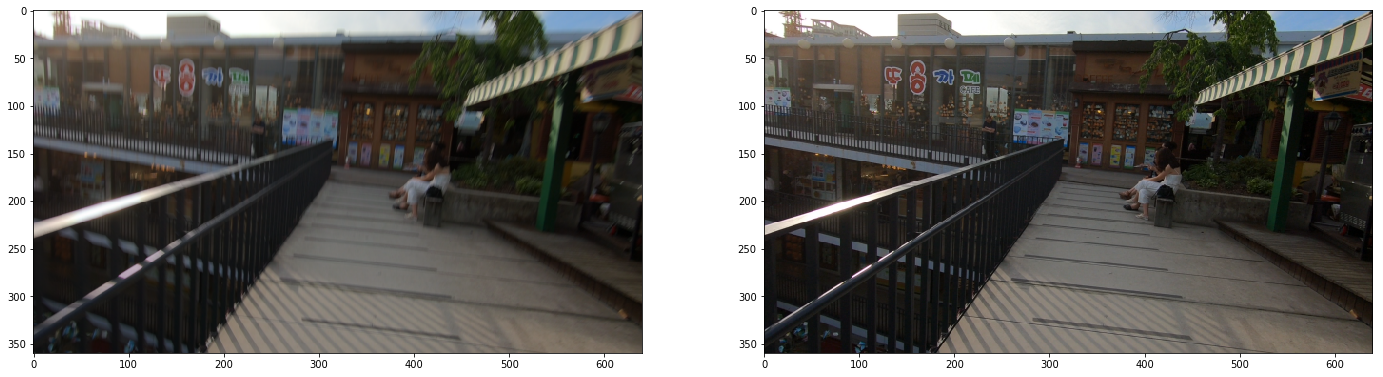

In [24]:
batch_size=1
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

a = next(iter(dataloader))

print(a[1].shape)
print(a[0].shape)
img1 = a[0][0]
img2 = a[1][0]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1.permute(1,2,0))
axarr[1].imshow(img2.permute(1,2,0))
f.set_figheight(24)
f.set_figwidth(24)

In [25]:
# torch.manual_seed(50)
# torch.cuda.manual_seed(50)

In [26]:
# netD = Discriminator().to(device).apply(weights_init)
netG = Generator(False,block_config =block_config,num_encoded_channels = num_encoded_channels).to(device)


177 4
181 4
274 4
278 4
340 4
344 4


In [27]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    try:
        torch.nn.init.xavier_uniform(m.weight)
    except:
        _
#         print(m)
_ = netG.apply(init_weights)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [28]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [29]:
valid_batch = next(iter(dataloader))

In [30]:
num_epochs = 40
iters = 0
# ssim_loss = SSIM().to(device)
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (imagesset) in enumerate(dataloader, 0):
        netG.train()
        output_heatmap = netG(imagesset[0].to(device))
        real_heatmap = imagesset[1].to(device)
        netG.zero_grad()
#         print("Heyy MSSIM : ",mssimmodel(output_heatmap,real_heatmap))
        errG = 4*l1criterion(output_heatmap,real_heatmap)+msecriterion(output_heatmap,real_heatmap)
        errG.backward(retain_graph=True)
        optimizerG.step()
        errg_item = errG.item()
        del real_heatmap , output_heatmap ,errG
        torch.cuda.empty_cache()
        
        if iters%50 == 0:
            netG.eval()
            blur_images = valid_batch[0].to(device)
            output_heatmap = netG(blur_images)
            del blur_images
            torch.cuda.empty_cache()
            real_heatmap = valid_batch[1].to(device)
            f, axarr = plt.subplots(1,2)
            validimg = (real_heatmap[0].cpu().detach().permute(1, 2, 0) )
            rec_img =  (output_heatmap[0].cpu().detach().permute(1, 2, 0))
            axarr[0].imshow(validimg)
            axarr[1].imshow(rec_img)
            f.set_figheight(20)
            f.set_figwidth(20)
            plt.show()
#             ssim_out = -ssim_loss(output_heatmap,real_heatmap)
#             ssim_value = - ssim_out.item()

#             print("Heyy MSSIM : ",ssim_value)
            del real_heatmap , output_heatmap
            torch.cuda.empty_cache()

        iters += 1
        if i%50 ==0:
            print('[%d/%d][%d/%d]\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader),errg_item))
# #             lr = lr/1.8
# #             optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
#             netG.eval()
#             reconstructed_img = netG(valid_batch)
#             f, axarr = plt.subplots(num_images_to_show,2)
            
#             validimg = (valid_batch[0].cpu().detach().permute(1, 2, 0)*0.5)+0.5
#             rec_img =  validimg + reconstructed_img[0].cpu().detach().permute(1, 2, 0) * 0.5
#             axarr[0].imshow(validimg)
#             axarr[1].imshow(rec_img)
#             f.set_figheight(20)
#             f.set_figwidth(20)
#             plt.show()
#             del reconstructed_img,validimg,rec_img
#             torch.cuda.empty_cache()


Starting Training Loop...


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 15.90 GiB total capacity; 15.12 GiB already allocated; 5.88 MiB free; 15.24 GiB reserved in total by PyTorch)

In [31]:
torch.save(netG, "netG.model")

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type _DenseBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type _DenseLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/py

In [32]:
netG.eval()
valid_batch = next(iter(dataloader))
blur_images = valid_batch[0].to(device)
output_heatmap = netG(blur_images)
rec_img =  (output_heatmap[0].cpu())

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 15.12 GiB already allocated; 5.88 MiB free; 15.24 GiB reserved in total by PyTorch)

In [33]:
print(rec_img.shape)

NameError: name 'rec_img' is not defined

In [34]:
rimage = rec_img.detach().permute(1, 2, 0)
plt.imshow(rimage)

NameError: name 'rec_img' is not defined

In [35]:
rimage = rec_img.detach().permute(1, 2, 0)
plt.imshow(rimage)

NameError: name 'rec_img' is not defined

In [36]:
print(rimage.shape)

NameError: name 'rimage' is not defined

In [37]:
netG.eval()
for _ in range(4):
    valid_batch = next(iter(dataloader))
    blur_images = valid_batch[0].to(device)
    output_heatmap = netG(blur_images)
#     real_heatmap = valid_batch[1].to(device)
    f, axarr = plt.subplots(1,2)
    print(output_heatmap.shape)
    validimg = (blur_images[0].cpu().detach().permute(1, 2, 0) )
    rec_img =  (output_heatmap[0].cpu().detach().permute(1, 2, 0))
    axarr[0].imshow(validimg)
    axarr[1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
    plt.show()
    #             ssim_out = -ssim_loss(output_heatmap,real_heatmap)
    #             ssim_value = - ssim_out.item()

    #             print("Heyy MSSIM : ",ssim_value)
    del output_heatmap
    torch.cuda.empty_cache()
    del blur_images
    torch.cuda.empty_cache()


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 15.12 GiB already allocated; 5.88 MiB free; 15.24 GiB reserved in total by PyTorch)